In [64]:
import torch, torchvision
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from tqdm import tqdm


In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device

device(type='cuda', index=0)

In [6]:
T = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  # torchvision.transforms.Lambda(lambda x: torch.flatten(x))
])
train_set = torchvision.datasets.MNIST("mnist_data", train=True, download=True, transform=T)
print(train_set)
test_set = torchvision.datasets.MNIST("mnist_data", train=False, download=True, transform=T)
print(test_set)

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: mnist_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [7]:
BATCH_SIZE = 64
train_dl = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_set, batch_size = 1, shuffle=True)

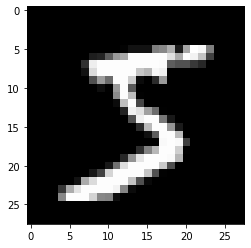

In [8]:
plt.imshow(train_set[0][0][0], cmap="gray")

# Flattened AE

In [152]:
class MNIST_AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        self.encoder = torch.nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )

        self.bottleneck = nn.Linear(16, 2)

        self.decoder = torch.nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid(),
            nn.Unflatten(1,[28,28])
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        bottlenecked = self.bottleneck(encoded)

        decoded = self.decoder(bottlenecked)
        return decoded, bottlenecked

In [153]:
# INSTANTIATE NEW
LOAD = True
auto_encoder = None
if LOAD:
  auto_encoder = torch.load("auto_encoder_flattened.pt")
  print(auto_encoder.eval())
else:
  auto_encoder = MNIST_AE()
  print(auto_encoder.eval())


MNIST_AE(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=16, bias=True)
    (8): ReLU()
  )
  (bottleneck): Linear(in_features=16, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=784, bias=True)
    (9): Sigmoid()
    (10): Unflatten(dim=1, unflattened_size=[28, 28])
  )
)


  0%|          | 0/10 [00:00<?, ?it/s]

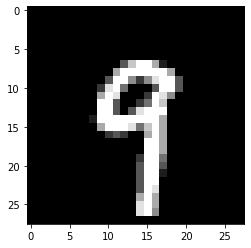

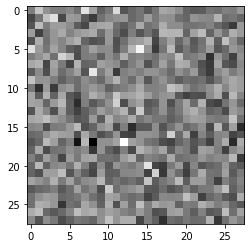

 10%|█         | 1/10 [00:25<03:50, 25.61s/it]

0.2281104428554649


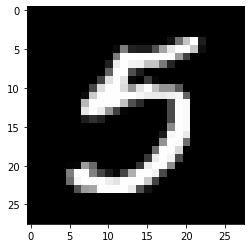

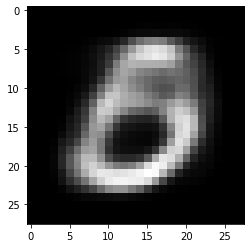

 20%|██        | 2/10 [00:48<03:11, 23.88s/it]

0.20917061803691678


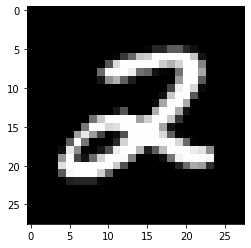

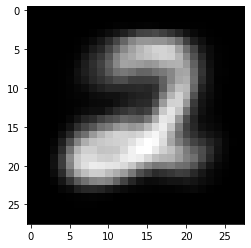

 30%|███       | 3/10 [01:10<02:42, 23.22s/it]

0.20686426984348785


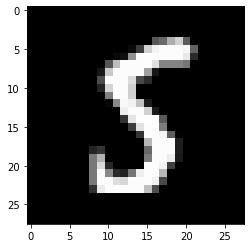

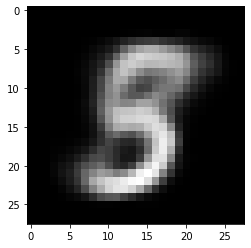

 40%|████      | 4/10 [01:34<02:20, 23.35s/it]

0.20629250197840143


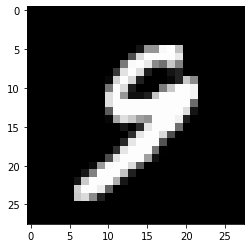

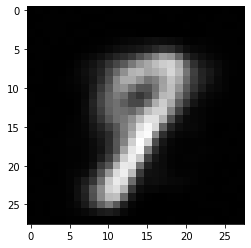

 50%|█████     | 5/10 [01:58<01:57, 23.55s/it]

0.20550494930192606


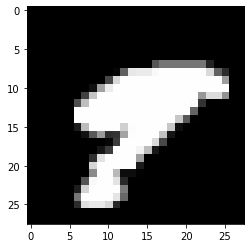

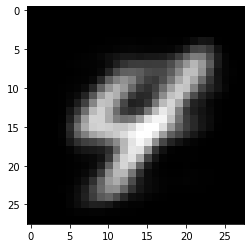

 60%|██████    | 6/10 [02:21<01:33, 23.44s/it]

0.20409136003395642


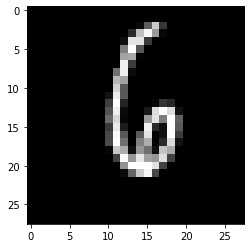

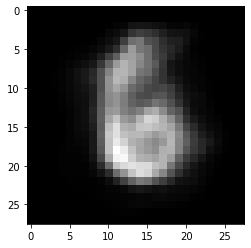

 70%|███████   | 7/10 [02:44<01:10, 23.39s/it]

0.20443583136873206


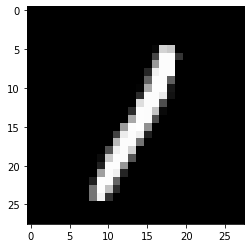

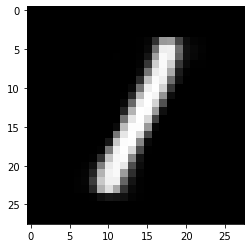

 80%|████████  | 8/10 [03:07<00:46, 23.33s/it]

0.2034875327653722


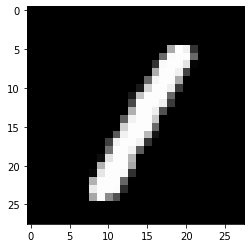

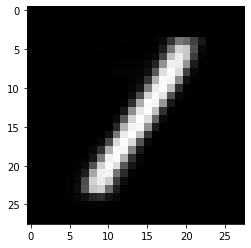

 90%|█████████ | 9/10 [03:31<00:23, 23.28s/it]

0.20293369002814995


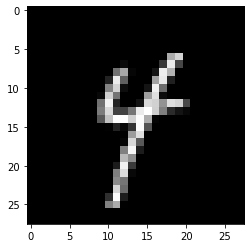

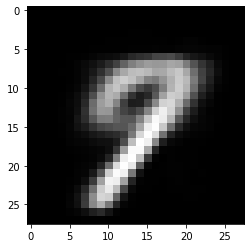

100%|██████████| 10/10 [03:54<00:00, 23.43s/it]

0.20447419755367327


In [11]:
EPOCHS = 10
auto_encoder = auto_encoder.to(device)
optimizer = torch.optim.Adam(auto_encoder.parameters(),
                             lr = 1e-2,
                             weight_decay = 1e-8)
criterion = nn.MSELoss()

for i in tqdm(range(EPOCHS)):
  sum_loss = 0 
  ctr = 0
  for j, (images, labels) in enumerate(train_dl):
    images = images.to(device)
    images = torch.squeeze(images)
    labels = labels.to(device)
    pred, bottlenecked = auto_encoder(images)

    #DISPLAY IMAGE
    if j == 0:
      plt.imshow(images[0].cpu(), cmap="gray")
      plt.show()
      plt.imshow(torch.Tensor.cpu(pred[0]).detach().numpy(), cmap = "gray")
      plt.show()

    #RMSE
    loss = torch.sqrt(criterion(pred, images))
    
    #GRADIENT DESCENT
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #LOSS LOG
    sum_loss += loss.item()
    ctr += 1
  print(sum_loss/ctr)

torch.save(auto_encoder, "auto_encoder_flattened.pt")

In [ ]:
encoded_samples = []
for sample in tqdm(test_set):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    cae.eval()
    with torch.no_grad():
       _, encoded_img  = cae(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7, width=800, height=800)


100%|██████████| 10000/10000 [01:00<00:00, 164.21it/s]


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'color=7<br>Enc. Variable 0=%{x}<br>Enc. Variable 1=%{y}<extra></extra>',
              'legendgroup': '7',
              'marker': {'color': '#636efa', 'opacity': 0.7, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '7',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([-22.348305, -28.832417, -27.858692, ..., -10.348992, -14.205189,
                          -13.627824], dtype=float32),
              'xaxis': 'x',
              'y': array([-0.9401703 ,  0.62282276,  3.8408465 , ..., -2.4976718 , -1.7746648 ,
                          -2.2924666 ], dtype=float32),
              'yaxis': 'y'},
             {'hovertemplate': 'color=2<br>Enc. Variable 0=%{x}<br>Enc. Variable 1=%{y}<extra></extra>',
              'legendgroup': '2',
              'marker': {'color': '#EF553B', 'opacity': 0.7, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '2',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([-4.846253  ,  0.4396181 , -3.671832  , ..., -0.86462796, -3.5705884 ,
                          -0.26471263], dtype=float32),
              'xaxis': 'x',
              'y': array([ 0.36651385, -3.0086503 , -0.35731304, ..., -0.94472253, -1.4677756 ,
                          -2.6996994 ], dtype=float32),
              'yaxis': 'y'},
             {'hovertemplate': 'color=1<br>Enc. Variable 0=%{x}<br>Enc. Variable 1=%{y}<extra></extra>',
              'legendgroup': '1',
              'marker': {'color': '#00cc96', 'opacity': 0.7, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '1',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([-43.660156, -30.739399, -47.29967 , ..., -13.051697, -31.746374,
                          -33.639088], dtype=float32),
              'xaxis': 'x',
              'y': array([-16.762774, -11.401979, -11.302595, ..., -11.534054,  -7.955976,
                          -13.274334], dtype=float32),
              'yaxis': 'y'},
             {'hovertemplate': 'color=0<br>Enc. Variable 0=%{x}<br>Enc. Variable 1=%{y}<extra></extra>',
              'legendgroup': '0',
              'marker': {'color': '#ab63fa', 'opacity': 0.7, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '0',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([-1.8741872, -3.4696398, -3.523637 , ..., -0.5552319, -2.7440724,
                          -0.6173171], dtype=float32),
              'xaxis': 'x',
              'y': array([0.7248008 , 1.6282854 , 1.4495677 , ..., 0.59382606, 1.5826906 ,
                          1.1105953 ], dtype=float32),
              'yaxis': 'y'},
             {'hovertemplate': 'color=4<br>Enc. Variable 0=%{x}<br>Enc. Variable 1=%{y}<extra></extra>',
              'legendgroup': '4',
              'marker': {'color': '#FFA15A', 'opacity': 0.7, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '4',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([-14.815355 , -11.835856 , -14.19647  , ...,  -8.2199545, -12.610078 ,
                          -10.225838 ], dtype=float32),
              'xaxis': 'x',
              'y': array([ 2.0978575 , -0.6285336 ,  0.968691  , ..., -2.2568598 , -0.72230685,
                          -1.7990488 ], dtype=float32),
              'yaxis': 'y'},
             {'hovertemplate': 'color=9<br>Enc. Variable 0=%{x}<br>Enc. Variable 1=%{y}<extra></extra>',
              'legendgroup': '9',
              'marker': {'color': '#19d3f3', 'opacity': 0.7, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '9',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([-11.807908, -10.512774, -13.567018, ..., -12.990272, -11.517396,
                         

# Convolutional AE

In [148]:
class MNIST_CAE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(),
        )

        self.encoder_dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )

        self.bottleneck = nn.Linear(16, 2)

        self.decoder_dense = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 3 * 3 * 32),
            nn.Unflatten(1, [32, 3, 3])
        )

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoder_conv = self.encoder_conv(x)
        encoder_dense = self.encoder_dense(encoder_conv)
        bottlenecked = self.bottleneck(encoder_dense)
        decoder_dense = self.decoder_dense(bottlenecked)
        decoder_conv = self.decoder_conv(decoder_dense)
        return decoder_conv, bottlenecked


In [149]:
cae = MNIST_CAE()
print(cae.eval())

MNIST_CAE(
  (encoder_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU()
  )
  (encoder_dense): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=288, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=16, bias=True)
    (6): ReLU()
  )
  (bottleneck): Linear(in_features=16, out_features=2, bias=True)
  (decoder_dense): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=3

  0%|          | 0/5 [00:00<?, ?it/s]

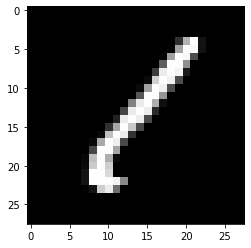

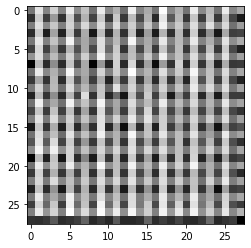

 20%|██        | 1/5 [00:34<02:17, 34.30s/it]

0.2582106986788036


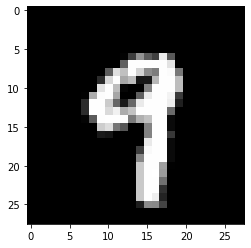

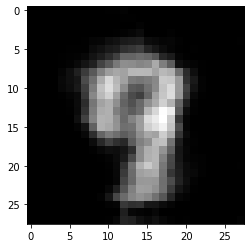

 40%|████      | 2/5 [01:07<01:41, 33.91s/it]

0.22441743361924502


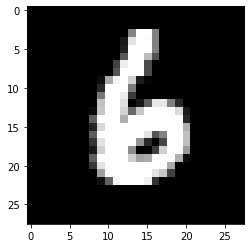

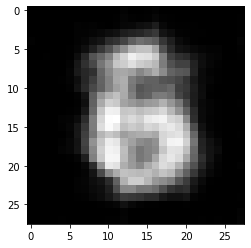

 60%|██████    | 3/5 [01:40<01:06, 33.36s/it]

0.2163561871056872


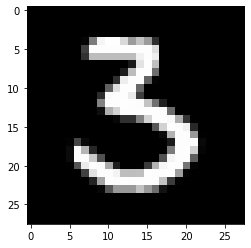

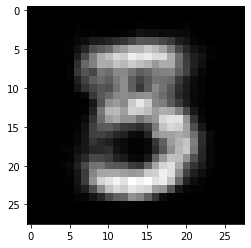

 80%|████████  | 4/5 [02:10<00:31, 31.96s/it]

0.21098872085115802


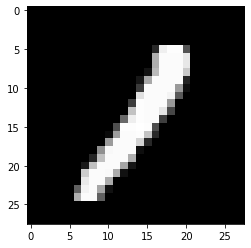

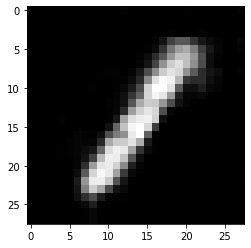

100%|██████████| 5/5 [02:38<00:00, 31.77s/it]

0.20777774645067226


In [150]:
torch.manual_seed(42)

EPOCHS = 5
cae = cae.to(device)
optimizer = torch.optim.Adam(cae.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-8)
criterion = nn.MSELoss()

for i in tqdm(range(EPOCHS)):
  sum_loss = 0 
  ctr = 0
  for j, (images, labels) in enumerate(train_dl):
    images = images.to(device)
    labels = labels.to(device)
    pred, bottlenecked = cae(images)

    #DISPLAY IMAGE
    if j == 0:
      plt.imshow(torch.squeeze(images)[0].cpu(), cmap="gray")
      plt.show()
      plt.imshow(torch.Tensor.cpu(torch.squeeze(pred[0])).detach().numpy(), cmap = "gray")
      plt.show()

    #RMSE
    loss = torch.sqrt(criterion(pred, images))
    
    #GRADIENT DESCENT
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #LOSS LOG
    sum_loss += loss.item()
    ctr += 1
  print(sum_loss/ctr)

torch.save(cae, "cae.pt")

In [155]:
encoded_samples = []
for sample in tqdm(test_set):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    cae.eval()
    with torch.no_grad():
       _, encoded_img  = cae(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7, width=800, height=800)


100%|██████████| 10000/10000 [00:49<00:00, 200.51it/s]


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'color=7<br>Enc. Variable 0=%{x}<br>Enc. Variable 1=%{y}<extra></extra>',
              'legendgroup': '7',
              'marker': {'color': '#636efa', 'opacity': 0.7, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '7',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([-22.348305, -28.832417, -27.858692, ..., -10.348992, -14.205189,
                          -13.627824], dtype=float32),
              'xaxis': 'x',
              'y': array([-0.9401703 ,  0.62282276,  3.8408465 , ..., -2.4976718 , -1.7746648 ,
                          -2.2924666 ], dtype=float32),
              'yaxis': 'y'},
             {'hovertemplate': 'color=2<br>Enc. Variable 0=%{x}<br>Enc. Variable 1=%{y}<extra></extra>',
              'legendgroup': '2',
              'marker': {'color': '#EF553B', 'opacity': 0.7, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '2',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([-4.846253  ,  0.4396181 , -3.671832  , ..., -0.86462796, -3.5705884 ,
                          -0.26471263], dtype=float32),
              'xaxis': 'x',
              'y': array([ 0.36651385, -3.0086503 , -0.35731304, ..., -0.94472253, -1.4677756 ,
                          -2.6996994 ], dtype=float32),
              'yaxis': 'y'},
             {'hovertemplate': 'color=1<br>Enc. Variable 0=%{x}<br>Enc. Variable 1=%{y}<extra></extra>',
              'legendgroup': '1',
              'marker': {'color': '#00cc96', 'opacity': 0.7, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '1',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([-43.660156, -30.739399, -47.29967 , ..., -13.051697, -31.746374,
                          -33.639088], dtype=float32),
              'xaxis': 'x',
              'y': array([-16.762774, -11.401979, -11.302595, ..., -11.534054,  -7.955976,
                          -13.274334], dtype=float32),
              'yaxis': 'y'},
             {'hovertemplate': 'color=0<br>Enc. Variable 0=%{x}<br>Enc. Variable 1=%{y}<extra></extra>',
              'legendgroup': '0',
              'marker': {'color': '#ab63fa', 'opacity': 0.7, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '0',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([-1.8741872, -3.4696398, -3.523637 , ..., -0.5552319, -2.7440724,
                          -0.6173171], dtype=float32),
              'xaxis': 'x',
              'y': array([0.7248008 , 1.6282854 , 1.4495677 , ..., 0.59382606, 1.5826906 ,
                          1.1105953 ], dtype=float32),
              'yaxis': 'y'},
             {'hovertemplate': 'color=4<br>Enc. Variable 0=%{x}<br>Enc. Variable 1=%{y}<extra></extra>',
              'legendgroup': '4',
              'marker': {'color': '#FFA15A', 'opacity': 0.7, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '4',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([-14.815355 , -11.835856 , -14.19647  , ...,  -8.2199545, -12.610078 ,
                          -10.225838 ], dtype=float32),
              'xaxis': 'x',
              'y': array([ 2.0978575 , -0.6285336 ,  0.968691  , ..., -2.2568598 , -0.72230685,
                          -1.7990488 ], dtype=float32),
              'yaxis': 'y'},
             {'hovertemplate': 'color=9<br>Enc. Variable 0=%{x}<br>Enc. Variable 1=%{y}<extra></extra>',
              'legendgroup': '9',
              'marker': {'color': '#19d3f3', 'opacity': 0.7, 'symbol': 'circle'},
              'mode': 'markers',
              'name': '9',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([-11.807908, -10.512774, -13.567018, ..., -12.990272, -11.517396,
                         